# Makemore P2

bigram -> neural bigram -> MLP

Everything stays the same. Optimization problem, trying to maximise the probability of the correct next character. We are going to make the neural network more complicated!

In [43]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
generator = torch.Generator().manual_seed(2147483647)

In [5]:
words = open('names.txt', 'r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [6]:
chars = sorted(list(set("".join(words))))
char_to_int = dict()

for i in range (len(chars)):
    char_to_int[chars[i]] = i + 1

char_to_int["."] = 0
int_to_chars = ["."]+chars
char_to_int

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [35]:
# Prepare Dataset
xs, ys = [], []

for w in words[:10]:

    chs = ["."] + ["."] + ["."] + list(w) + ["."]
    for ch1, ch2, ch3, ch4 in zip(chs,chs[1:],chs[2:],chs[3:]):

        ind1 = char_to_int[ch1]
        ind2 = char_to_int[ch2]
        ind3 = char_to_int[ch3]
        ind4 = char_to_int[ch4]

        xs.append([ind1,ind2,ind3])
        ys.append(ind4)

        # print("get {}{}{} pred {}".format(ch1,ch2,ch3,ch4))

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num_examples = len(xs)
print("Num of examples: ", num_examples)

Num of examples:  67


In [36]:
for x, y in zip(xs[:10], ys[:10]):
    print("When input is: ", x, " output is: ", y.item())


When input is:  tensor([0, 0, 0])  output is:  5
When input is:  tensor([0, 0, 5])  output is:  13
When input is:  tensor([ 0,  5, 13])  output is:  13
When input is:  tensor([ 5, 13, 13])  output is:  1
When input is:  tensor([13, 13,  1])  output is:  0
When input is:  tensor([0, 0, 0])  output is:  15
When input is:  tensor([ 0,  0, 15])  output is:  12
When input is:  tensor([ 0, 15, 12])  output is:  9
When input is:  tensor([15, 12,  9])  output is:  22
When input is:  tensor([12,  9, 22])  output is:  9


In [40]:
vocab_size = 27
context_length = 3
embedding_size = 2
W1_size = 100

# Define Parameters
C = torch.normal(mean=0,std=1, size=(vocab_size,embedding_size)) #init with small random numbers near zero
W1 = torch.normal(mean=0,std=1, size=(context_length*embedding_size,W1_size))
b1 = torch.normal(mean=0,std=1, size=(1,W1_size))
W2 = torch.normal(mean=0,std=1, size=(W1_size,vocab_size))
b2 = torch.normal(mean=0,std=1, size=(1,vocab_size))


Cross Entropy Loss - https://en.wikipedia.org/wiki/Cross-entropy

Imagine a probability distribution smeared across a discrete/continous space, I want to maximise the probability mass over the desired area.

Probs are between 0 - 1. If we take the negative log of a prob, then it turns into into a very nice loss function we can minimise.

Using the softmax function, we are able to take the output of a neural network, which can be +/- numbers, and turn them into a probability distribution 

One issue I have having is of numerical stability though. e^108 is a huge number..

In [22]:
torch.exp(torch.Tensor([4]))

# Therefore, the value of e is equal to 2.71828 or e ≈ 2.72.

tensor([54.5981])

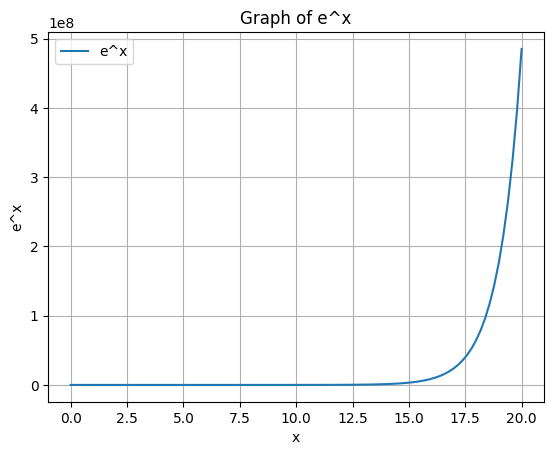

In [25]:
x = torch.linspace(0, 20, 100)  # Create 100 points from 0 to 4

# Compute e^x for each value of x
y = torch.exp(x)

# Plot the graph
plt.plot(x.numpy(), y.numpy(), label='e^x')
plt.xlabel('x')
plt.ylabel('e^x')
plt.title('Graph of e^x')
plt.legend()
plt.grid(True)
plt.show()

Andrej has some notes on this in CS231n

https://cs231n.github.io/linear-classify/

In [65]:
# Different ways to do embedding

#1 Indexing, as explained in paper
print(C[0])

# First layer in neural net with one hot enocded inputs
xenc = F.one_hot(torch.arange(0, 1), num_classes=27).float()
print(xenc.shape, C.shape)
print(xenc @ C)

# By Matrix/list
print(C[[0,0]])

print(xs[0])
print(C[xs[0]])
print(C[xs[:2]].shape)
print(C[xs[:5]].shape)

tensor([-0.3468,  2.0272])
torch.Size([1, 27]) torch.Size([27, 2])
tensor([[-0.3468,  2.0272]])
tensor([[-0.3468,  2.0272],
        [-0.3468,  2.0272]])
tensor([0, 0, 0])
tensor([[-0.3468,  2.0272],
        [-0.3468,  2.0272],
        [-0.3468,  2.0272]])
torch.Size([2, 3, 2])
torch.Size([5, 3, 2])


In [45]:
# Forward Pass

#one at a time


for i in range(1):
    x = xs[i]
    x_embed = torch.cat((C[x[0]],C[x[1]],C[x[2]])).reshape(1,-1)
    l1 = torch.max(x_embed @ W1 + b1, torch.tensor(0))
    log_counts = l1 @ W2 + b2
    print(log_counts)
    log_counts -= torch.max(log_counts)
    print(log_counts)
    #softmax
    counts = torch.exp(log_counts)
    print(counts)
    probs = counts/counts.sum()
    y = ys[i].item()
    print(y)
    print(probs.shape)
    class_probs = probs[0,y]
    print(class_probs)
    logprob = -torch.log(class_probs) #goes from +inf (p=0) to 0 (p=1)
    print(logprob)

# man... backprop is going to be a pain!!!

tensor([[ 29.0231, -14.0361,  11.9878,  13.5426, -54.7978,  31.5856,  12.1069,
           9.1979, -16.6081,  -9.1634,  10.8570,   6.2493, -47.2183, -15.4378,
         -16.3714, -19.5308, -11.9488,  45.3429,  -8.8162, -25.0450,   4.2826,
         -11.0285, -32.3493,  -5.3225, -47.9451, -52.3404, -18.7610]])
tensor([[ -16.3198,  -59.3790,  -33.3551,  -31.8003, -100.1407,  -13.7573,
          -33.2360,  -36.1450,  -61.9510,  -54.5063,  -34.4859,  -39.0936,
          -92.5612,  -60.7807,  -61.7143,  -64.8737,  -57.2917,    0.0000,
          -54.1591,  -70.3879,  -41.0603,  -56.3714,  -77.6922,  -50.6654,
          -93.2879,  -97.6833,  -64.1039]])
tensor([[8.1732e-08, 1.6294e-26, 3.2662e-15, 1.5464e-14, 3.2230e-44, 1.0600e-06,
         3.6794e-15, 2.0064e-16, 1.2446e-27, 2.1292e-24, 1.0543e-15, 1.0516e-17,
         6.3267e-41, 4.0112e-27, 1.5770e-27, 6.6943e-29, 1.3138e-25, 1.0000e+00,
         3.0130e-24, 2.6973e-31, 1.4715e-18, 3.2976e-25, 1.8143e-34, 9.9149e-23,
         3.0589e-41, 3.7

Key Ideas is that we are going to learn the embeddings (is this a encoder v1?)

Naively if you feed a=1, b=2, c=3 into the network, then there is a bias as a and b are similar. 

Instead we can represent each symbol as a point in n-dimensional space. and have the network learn what that point is. We would then expect conceptually similar symbols to be close in space!